# Notebook: Compare Model Performance

In [120]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
import statsmodels.api as sm
from scipy import stats
import numpy as np
import json

In [121]:
json_path_only_real = "../07 train models/results_json/results_only_real_real500_synth0_aspect_category_sentiment_random.json"
json_path_with_synth = "../07 train models/results_json/results_GPT-3_real500_synth500_aspect_category_sentiment_random.json"


with open(json_path_only_real, 'r') as json_file:
     results_only_real = json.load(json_file)

with open(json_path_with_synth, 'r') as json_file:
     results_with_synth = json.load(json_file)

In [122]:
only_real_f1 = [res["eval_f1_macro"]  for res in results_only_real["single_split_results"]]
with_synth_f1 = [res["eval_f1_macro"]  for res in results_with_synth["single_split_results"]]

In [123]:
from scipy.stats import ttest_rel
import numpy as np

# F1-Scores für Modell A und B
only_real_f1 = [res["eval_f1_macro"] for res in results_only_real["single_split_results"]]
with_synth_f1 = [res["eval_f1_macro"] for res in results_with_synth["single_split_results"]]

# Gepaarter t-Test
t_statistic, p_value = ttest_rel(only_real_f1, with_synth_f1)

# Berechnung des 95% Konfidenzintervalls für den Unterschied
mean_diff = np.mean(only_real_f1) - np.mean(with_synth_f1)
std_diff = np.std(np.array(only_real_f1) - np.array(with_synth_f1), ddof=1)  # ddof=1 für unbiased Schätzung der Standardabweichung
ci_lower = mean_diff - 1.96 * (std_diff / np.sqrt(len(only_real_f1)))
ci_upper = mean_diff + 1.96 * (std_diff / np.sqrt(len(only_real_f1)))

# Ausgabe der Ergebnisse
print(f"Gepaarter t-Test: t = {t_statistic}, p = {p_value}")
print(f"95% Konfidenzintervall für den Unterschied: ({ci_lower}, {ci_upper})")



Gepaarter t-Test: t = -5.137176097937245, p = 0.0036539864327732917
95% Konfidenzintervall für den Unterschied: (-0.2625889773204397, -0.11755258863687605)


In [124]:
from scipy.stats import shapiro

# Berechnung der Differenzen
differences = np.array(only_real_f1) - np.array(with_synth_f1)

# Shapiro-Wilk-Test auf Normalverteilung
statistic, p_value = shapiro(differences)

# Ausgabe der Ergebnisse
print(f"Shapiro-Wilk-Test: Statistik = {statistic}, p = {p_value}")

# Interpretation des Tests
alpha = 0.05
if p_value > alpha:
    print("Die Differenzen könnten normalverteilt sein (nicht signifikant)")
else:
    print("Die Differenzen sind möglicherweise nicht normalverteilt (signifikant)")


Shapiro-Wilk-Test: Statistik = 0.9335893988609314, p = 0.6080922484397888
Die Differenzen könnten normalverteilt sein (nicht signifikant)


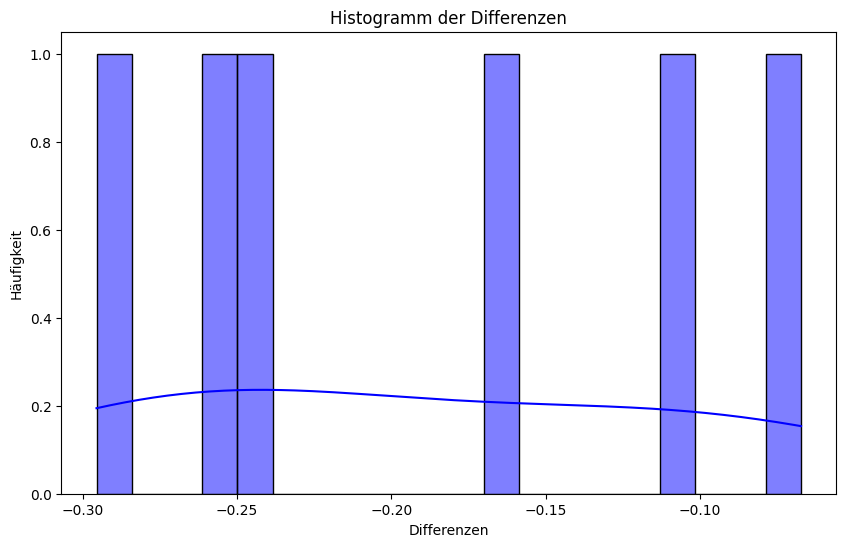

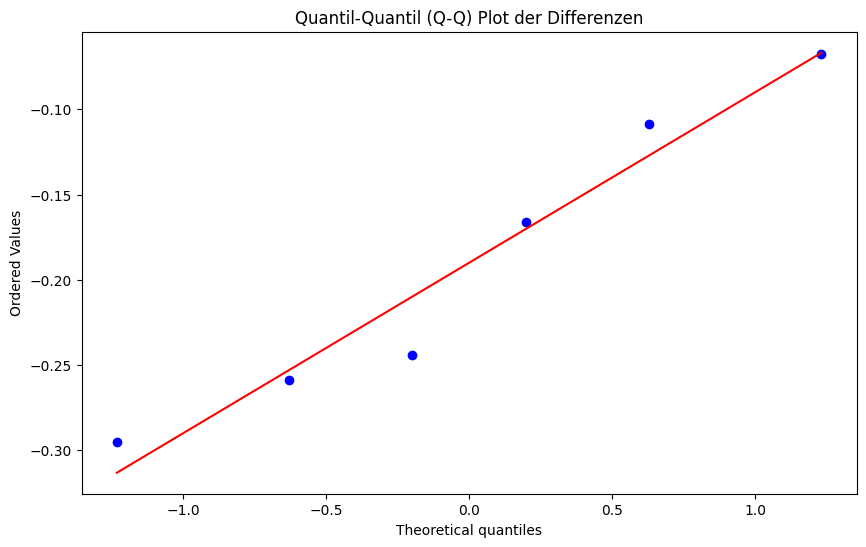

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Berechnung der Differenzen
differences = np.array(only_real_f1) - np.array(with_synth_f1)

# Histogramm der Differenzen
plt.figure(figsize=(10, 6))
sns.histplot(differences, kde=True, bins=20, color='blue')
plt.title('Histogramm der Differenzen')
plt.xlabel('Differenzen')
plt.ylabel('Häufigkeit')
plt.show()

# Quantil-Quantil (Q-Q) Plot
plt.figure(figsize=(10, 6))
probplot(differences, plot=plt)
plt.title('Quantil-Quantil (Q-Q) Plot der Differenzen')
plt.show()
